# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [2]:
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F

def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_scenario() -> tuple[State, Action]:
    """
    Generates a random scenario
    """
    # generate a random state
    velocity = np.random.multivariate_normal([0, 0], np.eye(2) * 100)
    heading = normalize_angle(np.arctan2(velocity[1], velocity[0]) + np.random.normal(0, np.pi/4))

    s = State(heading=heading, velocity=velocity)

    # generate a random action
    steer = np.random.uniform(-1, 1)
    throttle = np.random.uniform(-1, 1)
    a = (steer, throttle)

    return s, a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 3)
    """

    return torch.tensor(np.stack([
        [st.velocity[0], st.velocity[1], st.heading] for st in states
    ]), dtype=torch.float32, device=device)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


This task may take a few minutes to run the first time.

In [3]:
def generate_data(n_scenarios: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n_scenarios):
        s0, a = gen_scenario()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [7]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16
DATASET_SIZE = 80000


mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(DATASET_SIZE, MAX_WORKERS)
    for batch in executor.map(generate_data, [*[batch_size]*MAX_WORKERS, leftover_size]):
        mm_train_data.extend(batch)

:device:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/e

In [7]:
mm_validation_data = generate_data(1000)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


In [8]:
import pickle
import os

# pickle the data
if not os.path.exists('data/mm_train_data.pkl'):
    with open('data/mm_train_data.pkl', 'wb') as f:
        pickle.dump(mm_train_data, f)

if not os.path.exists('data/mm_validation_data.pkl'):
    with open('data/mm_validation_data.pkl', 'wb') as f:
        pickle.dump(mm_validation_data, f)



In [4]:
import pickle
import os

if 'mm_train_data' not in locals():
    # load data (if exists)   
    with open('data/mm_train_data.pkl', 'rb') as f:
        mm_train_data = pickle.load(f)

if 'mm_validation_data' not in locals():
    with open('data/mm_validation_data.pkl', 'rb') as f:
        mm_validation_data = pickle.load(f)

In [5]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

training data: 40000
validation data: 1000


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(5, 512) # Bx5 -> Bx512
        self.fc2 = nn.Linear(512, 512) # Bx512 -> Bx256
        self.fc3 = nn.Linear(512, 3) # Bx256 -> Bx3
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        x = torch.cat([states, actions], dim=1) # Bx5
        x = F.relu(self.fc1(x)) # Bx512
        x = F.relu(self.fc2(x)) # Bx512
        x = self.fc3(x) # Bx3
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [7]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.Adam(mm.parameters())

mm_step = 0
mm_losses = []

In [36]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 15000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 4096

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch = [s0 for s0, _, _ in data_batch]
    a_batch = [a for _, a, _ in data_batch]
    s1_batch = [s1 for _, _, s1 in data_batch]
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 100 == 0:
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 100, Loss: 0.217
Step: 200, Loss: 0.120
Step: 300, Loss: 0.106
Step: 400, Loss: 0.101
Step: 500, Loss: 0.095
Step: 600, Loss: 0.090
Step: 700, Loss: 0.086
Step: 800, Loss: 0.080
Step: 900, Loss: 0.077
Step: 1000, Loss: 0.073
Step: 1100, Loss: 0.073
Step: 1200, Loss: 0.069
Step: 1300, Loss: 0.066
Step: 1400, Loss: 0.063
Step: 1500, Loss: 0.059
Step: 1600, Loss: 0.056
Step: 1700, Loss: 0.057
Step: 1800, Loss: 0.054
Step: 1900, Loss: 0.052
Step: 2000, Loss: 0.051
Step: 2100, Loss: 0.047
Step: 2200, Loss: 0.045
Step: 2300, Loss: 0.045
Step: 2400, Loss: 0.044
Step: 2500, Loss: 0.042
Step: 2600, Loss: 0.041
Step: 2700, Loss: 0.038
Step: 2800, Loss: 0.036
Step: 2900, Loss: 0.038
Step: 3000, Loss: 0.036
Step: 3100, Loss: 0.035
Step: 3200, Loss: 0.034
Step: 3300, Loss: 0.031
Step: 3400, Loss: 0.030
Step: 3500, Loss: 0.029
Step: 3600, Loss: 0.031
Step: 3700, Loss: 0.030
Step: 3800, Loss: 0.029
Step: 3900, Loss: 0.029
Step: 4000, Loss: 0.026
Step: 4100, Loss: 0.025
Step: 4200, Loss: 0.027
S

In [9]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

In [37]:
# save mm
if not os.path.exists('data/mm.pth'):
    torch.save(mm.state_dict(), 'data/mm.pth')

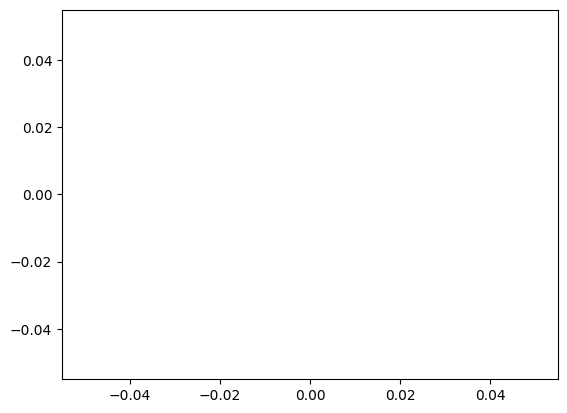

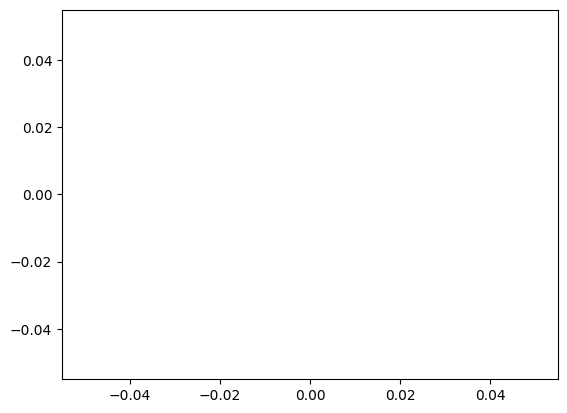

In [10]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

In [39]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("validation loss", loss.mean().item())

validation loss 0.02123415097594261


In [40]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("training loss", loss.mean().item())



training loss 0.006551372818648815


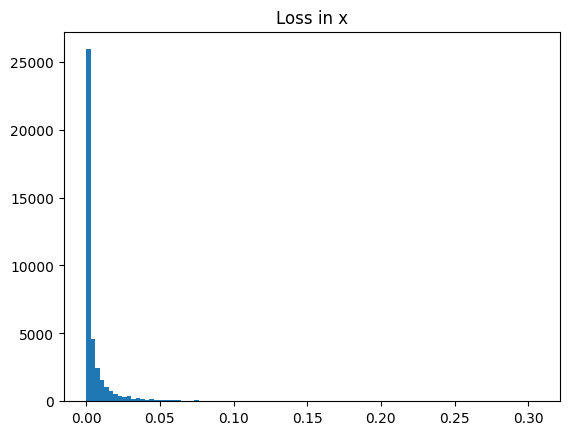

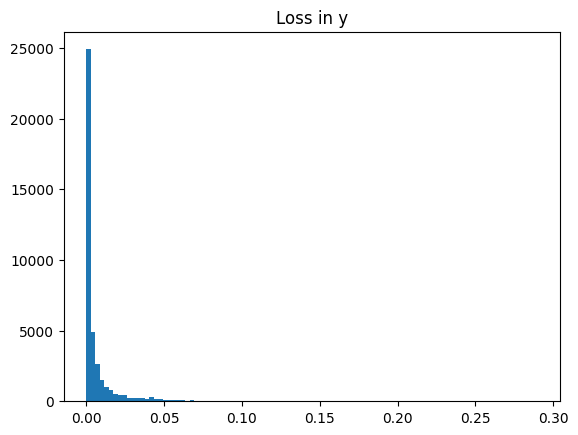

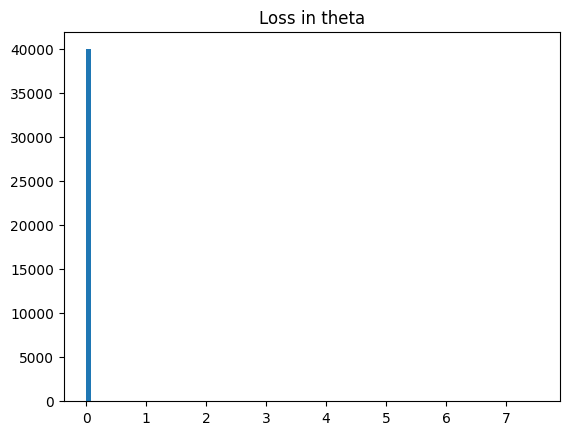

In [41]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()


Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [11]:
from protos import scenario_pb2
# tensorflow don't allocate all gpu memory right away
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tqdm

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]


files = getFiles('~/data/waymo/')

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in tf.data.TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


2023-08-11 22:47:16.225994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 22:47:17.379143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  0%|          | 0/100 [00:00<?, ?it/s]2023-08-11 22:47:18.204849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-11 22:47:18.224628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at l

KeyboardInterrupt: 

In [12]:
idm_train_data: list[Observation] = []
for states in h:
    for i in range(len(states)-1):
        idm_train_data.append((states[i], states[i+1]))

print("train data:", len(idm_train_data))

train data: 145374


In [13]:
import pickle
import os

# pickle the data
if not os.path.exists('data/idm_train_data.pkl'):
    with open('data/idm_train_data.pkl', 'wb') as f:
        pickle.dump(idm_train_data, f)

In [ ]:
import pickle
import os

if 'idm_train_data' not in locals():
    # load data (if exists)   
    with open('data/idm_train_data.pkl', 'rb') as f:
        idm_train_data = pickle.load(f)

In [14]:
import random
random.shuffle(idm_train_data)

In [16]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 512, 2) # Bx3x2 -> Bx512x1
        self.fc1 = nn.Linear(512, 512) # Bx512 -> Bx512
        self.fc2 = nn.Linear(512, 2) # Bx512 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx512x1
        x = torch.flatten(x, 1) # Bx512x1 -> Bx512
        x = F.relu(self.fc1(x)) # Bx512 -> Bx512
        x = self.fc2(x) # Bx512 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [17]:
idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.Adam(idm.parameters())

idm_step = 0
idm_losses = []

In [26]:
set_lr(idm_optimizer, 5e-5)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 10000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 8192

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 100 == 0:
        print(f"Step: {idm_step}, Loss: {loss:.3f}")

Step: 3300, Loss: 0.011
Step: 3400, Loss: 0.019
Step: 3500, Loss: 0.028
Step: 3600, Loss: 0.010
Step: 3700, Loss: 0.014
Step: 3800, Loss: 0.017
Step: 3900, Loss: 0.017
Step: 4000, Loss: 0.013
Step: 4100, Loss: 0.022
Step: 4200, Loss: 0.027
Step: 4300, Loss: 0.011
Step: 4400, Loss: 0.012
Step: 4500, Loss: 0.022
Step: 4600, Loss: 0.022
Step: 4700, Loss: 0.013
Step: 4800, Loss: 0.015
Step: 4900, Loss: 0.017
Step: 5000, Loss: 0.018


KeyboardInterrupt: 

In [31]:
# load mm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('data/idm.pth'))    

In [ ]:
# save mm
if not os.path.exists('data/idm.pth'):
    torch.save(mm.state_dict(), 'data/idm.pth')

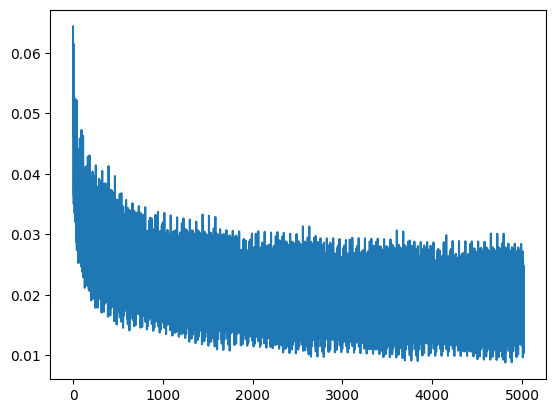

In [27]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

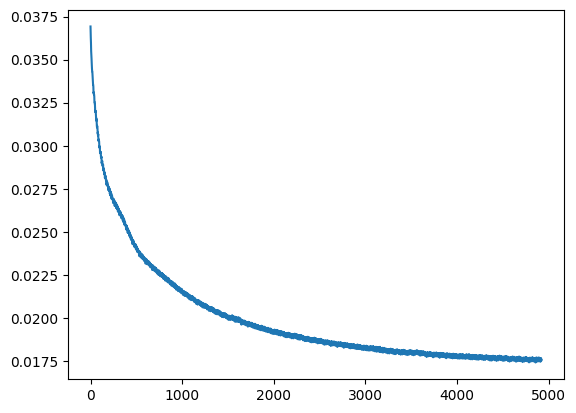

In [28]:
# compute running average of the last 100 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((100,))/100, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [29]:
obs_batch = idm_train_data[:8000]

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_batch, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("training loss", loss.mean().item())

training loss 0.010536502115428448


Let's try visualizing our IDM by having it follow a track from start to finish.

In [30]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [37]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [40]:
scenario = h[3]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)((st0, st1))
        print(action)
        env.step(action)

        

(0.16430507600307465, 0.07972487807273865)
(0.16489876806735992, 0.0800577700138092)
(0.16505776345729828, 0.08019989728927612)
(0.16530250012874603, 0.07999122142791748)
(0.16550061106681824, 0.08020853996276855)
(0.1650773584842682, 0.07910138368606567)
(0.16529512405395508, 0.07995855808258057)
(0.16595903038978577, 0.08118036389350891)
(0.16561460494995117, 0.08009746670722961)
(0.16523317992687225, 0.08035317063331604)
(0.16518637537956238, 0.07922413945198059)
(0.1659291386604309, 0.07987797260284424)
(0.16650228202342987, 0.08087244629859924)
(0.16598442196846008, 0.08078524470329285)
(0.16541187465190887, 0.07966025173664093)
(0.165016308426857, 0.07914680242538452)
(0.16482917964458466, 0.08073732256889343)
(0.16501012444496155, 0.08027471601963043)
(0.16508601605892181, 0.07869553565979004)
(0.1653221845626831, 0.07966567575931549)
(0.16547077894210815, 0.08038648962974548)
(0.1651037484407425, 0.07972392439842224)
(0.16515105962753296, 0.07984617352485657)
(0.165610700845718

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1652551293373108, 0.0790891945362091)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1651296615600586, 0.07896295189857483)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16514664888381958, 0.07981912791728973)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16590172052383423, 0.08100995421409607)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16624435782432556, 0.08078812062740326)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16600681841373444, 0.08093622326850891)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16582486033439636, 0.08026209473609924)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16533119976520538, 0.07954977452754974)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16466984152793884, 0.07919691503047943)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16435247659683228, 0.07946918904781342)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16447803378105164, 0.08031842112541199)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16511942446231842, 0.07950592041015625)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16540426015853882, 0.08030515909194946)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16537711024284363, 0.08039452135562897)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16531185805797577, 0.07972626388072968)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16533218324184418, 0.08047285676002502)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16536329686641693, 0.07985591888427734)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16532203555107117, 0.07937407493591309)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1654643714427948, 0.08009088039398193)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16560514271259308, 0.08046093583106995)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16565872728824615, 0.08090342581272125)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16549575328826904, 0.07986663281917572)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16520273685455322, 0.07964035868644714)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1654992252588272, 0.08086812496185303)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1662910133600235, 0.08072918653488159)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16648146510124207, 0.08025479316711426)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16605228185653687, 0.07963618636131287)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16546489298343658, 0.07975241541862488)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16499410569667816, 0.08051532506942749)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16505567729473114, 0.08061997592449188)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1656881421804428, 0.08045165240764618)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16585230827331543, 0.07995246350765228)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1650538444519043, 0.07873469591140747)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16515812277793884, 0.08004939556121826)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16592858731746674, 0.08147522807121277)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1663023680448532, 0.08073446154594421)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1656699776649475, 0.0799654871225357)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16542518138885498, 0.07952594757080078)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16577845811843872, 0.07978908717632294)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16504670679569244, 0.0801243782043457)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16490225493907928, 0.08005902171134949)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16586695611476898, 0.08068981766700745)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16586929559707642, 0.08039635419845581)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16532506048679352, 0.07904508709907532)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16557231545448303, 0.08021041750907898)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1658506840467453, 0.08116117119789124)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1654139757156372, 0.07935768365859985)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16471831500530243, 0.07830555737018585)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16494271159172058, 0.0801658183336258)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1654473841190338, 0.08078530430793762)


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


In [60]:
env.close()